# Восстановление золота из руды
## Описание проекта
Компания разрабатывает решения для эффективной работы промышленных предприятий. Представлены данные с параметрами добычи и очистки золотосодержащей руды. Необходимо построить модель машинного обучения.
Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды.
Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.
## Стадии технологического процесса:
1. *Флотация*.
Во флотационную установку подаётся смесь золотосодержащей руды. После обогащения получается черновой концентрат и «отвальные хвосты», то есть остатки продукта с низкой концентрацией ценных металлов.
На стабильность этого процесса влияет непостоянное и неоптимальное физико-химическое состояние флотационной пульпы (смеси твёрдых частиц и жидкости).
2. *Очистка*. 
Черновой концентрат проходит две очистки. На выходе получается финальный концентрат и новые отвальные хвосты.

<img src= "https://pictures.s3.yandex.net/resources/viruchka_1576238830.jpg" alt="Scheme" style="width: 600px;"/>

## Описание данных

**Технологический процесс**

`Rougher feed` — исходное сырье

`Rougher additions` (или `reagent additions`) — флотационные реагенты: Xanthate, Sulphate, Depressant

    Xanthate — ксантогенат (промотер, или активатор флотации);
    
    Sulphate — сульфат (на данном производстве сульфид натрия);
    
    Depressant — депрессант (силикат натрия).
    
`Rougher process` (англ. «грубый процесс») — флотация

`Rougher tails` — отвальные хвосты

`Float banks` — флотационная установка

`Cleaner process` — очистка

`Rougher Au` — черновой концентрат золота

`Final Au` — финальный концентрат золота

**Параметры этапов**

`air amount` — объём воздуха

`fluid levels` — уровень жидкости

`feed size` — размер гранул сырья

`feed rate` — скорость подачи

## Наименование признаков
Наименование признаков должно быть такое:
`этап`.`тип_параметра`.`название_параметра`

Возможные значения для блока `этап`:

`rougher` — флотация

`primary_cleaner` — первичная очистка

`secondary_cleaner` — вторичная очистка

`final` — финальные характеристики

Возможные значения для блока `тип_параметра`:

`input` — параметры сырья

`output` — параметры продукта

`state` — параметры, характеризующие текущее состояние этапа

`calculation` — расчётные характеристики
## Последовательность шагов проекта
1. Загрузка и исследование датасетов.
2. Исследовательский анализ данных.
3. Построение и проверка моделей.
4. Выбор и испытание лучшей модели.
## 1. Загрузка и исследование данных.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.dummy import DummyRegressor

plt.style.use('dark_background')

In [3]:
train_df.head()

,date,rougher.input.feed_au,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_sol,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.state.floatbank10_a_air,...,secondary_cleaner.output.tail_sol,final.output.concentrate_au,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.recovery,final.output.tail_au,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol
0,2016-01-15 00:00:00,6.486150,6.100378,2.284912,36.808594,523.546326,55.486599,11.986616,6.007990,999.706909,...,8.764648,42.192020,6.055403,9.889648,5.507324,70.541216,2.143149,10.411962,0.895447,16.904297
1,2016-01-15 01:00:00,6.478583,6.161113,2.266033,35.753385,525.290581,57.278666,11.971193,6.005766,1000.286398,...,9.001494,42.701629,6.029369,9.968944,5.257781,69.266198,2.224930,10.462676,0.927452,16.634514
2,2016-01-15 02:00:00,6.362222,6.116455,2.159622,35.971630,530.026610,57.510649,11.920603,6.197377,999.719565,...,8.842896,42.657501,6.055926,10.213995,5.383759,68.116445,2.257889,10.507046,0.953716,16.208849
3,2016-01-15 03:00:00,6.118189,6.043309,2.037807,36.862241,542.590390,57.792734,11.630094,6.203177,999.814770,...,9.122857,42.689819,6.047977,9.977019,4.858634,68.347543,2.146849,10.422762,0.883763,16.532835
4,2016-01-15 04:00:00,5.663707,6.060915,1.786875,34.347666,540.531893,56.047189,10.957755,6.198826,999.678690,...,8.871028,42.774141,6.148599,10.142511,4.939416,66.927016,2.055292,10.360302,0.792826,16.525686


In [4]:
test_df.head()

,date,rougher.input.feed_au,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_sol,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.state.floatbank10_a_air,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2017-12-09 14:59:59,4.365491,6.158718,3.875727,39.135119,555.820208,94.544358,6.146982,9.308612,1196.238112,...,23.018622,-500.492702,20.020205,-500.220296,17.963512,-499.939490,12.990306,-500.080993,19.990336,-499.191575
1,2017-12-09 15:59:59,4.362781,6.048130,3.902537,39.713906,544.731687,123.742430,6.210119,9.297709,1201.904177,...,23.024963,-501.153409,20.054122,-500.314711,17.979515,-499.272871,12.992404,-499.976268,20.013986,-500.625471
2,2017-12-09 16:59:59,5.081681,6.082745,4.564078,37.208683,558.155110,82.610855,7.363824,9.003562,1200.826926,...,22.993827,-501.559663,20.029144,-500.000662,18.012723,-500.024764,13.016445,-500.058432,19.973767,-501.394155
3,2017-12-09 17:59:59,5.145949,6.084374,4.768124,36.808874,539.713765,77.984784,6.927072,8.955597,1199.292489,...,23.032807,-501.287889,19.977466,-500.159903,17.980463,-500.504602,12.949071,-500.009937,20.010332,-508.337973
4,2017-12-09 18:59:59,5.735249,6.165220,4.512346,37.810642,558.713584,86.434874,7.823471,7.490356,1198.005449,...,23.001911,-499.947838,20.023735,-499.713680,17.990955,-500.334769,13.007523,-499.968459,19.995999,-499.788805


In [5]:
full_df.head()

,date,rougher.input.feed_au,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_sol,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.state.floatbank10_a_air,...,secondary_cleaner.output.tail_sol,final.output.concentrate_au,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.recovery,final.output.tail_au,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol
0,2016-01-15 00:00:00,6.486150,6.100378,2.284912,36.808594,523.546326,55.486599,11.986616,6.007990,999.706909,...,8.764648,42.192020,6.055403,9.889648,5.507324,70.541216,2.143149,10.411962,0.895447,16.904297
1,2016-01-15 01:00:00,6.478583,6.161113,2.266033,35.753385,525.290581,57.278666,11.971193,6.005766,1000.286398,...,9.001494,42.701629,6.029369,9.968944,5.257781,69.266198,2.224930,10.462676,0.927452,16.634514
2,2016-01-15 02:00:00,6.362222,6.116455,2.159622,35.971630,530.026610,57.510649,11.920603,6.197377,999.719565,...,8.842896,42.657501,6.055926,10.213995,5.383759,68.116445,2.257889,10.507046,0.953716,16.208849
3,2016-01-15 03:00:00,6.118189,6.043309,2.037807,36.862241,542.590390,57.792734,11.630094,6.203177,999.814770,...,9.122857,42.689819,6.047977,9.977019,4.858634,68.347543,2.146849,10.422762,0.883763,16.532835
4,2016-01-15 04:00:00,5.663707,6.060915,1.786875,34.347666,540.531893,56.047189,10.957755,6.198826,999.678690,...,8.871028,42.774141,6.148599,10.142511,4.939416,66.927016,2.055292,10.360302,0.792826,16.525686


По первым строкам данных видно, что в тестовой выборке отсутствует 34 столбца, которые есть в других датасетах. Посмотрим, что это за колонки

In [6]:
set(train_df.columns) - set(test_df.columns)

{'final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_au',
 'rougher.output.ta

Отсутствующие данные относятся к характеристикам продукта стадий переработки и расчетным характеристикам, т.к. они недоступны во время процесса. Нужно сохранить их в переменную для исключения из обучения модели в дальнейшем

In [7]:
missing_columns = list(set(train_df.columns) - set(test_df.columns))

In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14579 entries, 0 to 14578
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                14579 non-null  object 
 1   rougher.input.feed_au                               14579 non-null  float64
 2   rougher.input.feed_ag                               14579 non-null  float64
 3   rougher.input.feed_pb                               14507 non-null  float64
 4   rougher.input.feed_sol                              14502 non-null  float64
 5   rougher.input.feed_rate                             14572 non-null  float64
 6   rougher.input.feed_size                             14478 non-null  float64
 7   rougher.input.floatbank10_sulfate                   14548 non-null  float64
 8   rougher.input.floatbank10_xanthate                  14572 non-null  float64


В некоторых столбцах присутствуют пропуски. Т.к. данные представляют собой отсортированную по времени таблицу с часовыми интервалами, можно использовать заполнение пропусков предыдущим валидным значением. Пропусков в целевых параметрах нет.

In [9]:
train_df.describe()

,rougher.input.feed_au,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_sol,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,...,secondary_cleaner.output.tail_sol,final.output.concentrate_au,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.recovery,final.output.tail_au,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol
count,14579.000000,14579.000000,14507.000000,14502.000000,14572.000000,14478.000000,14548.000000,14572.000000,14579.000000,14579.000000,...,13659.000000,14579.000000,14578.000000,14578.000000,14387.000000,14579.000000,14579.000000,14578.000000,14504.000000,14574.000000
mean,8.352941,8.877460,3.604221,36.561420,474.332784,58.922712,12.427399,5.994854,1104.208278,-379.367166,...,7.111347,43.979499,5.192145,9.923809,9.566676,66.759066,3.087939,9.731972,2.719985,10.612745
std,1.934376,1.922536,1.056063,5.209823,108.503552,22.407410,3.428939,1.152873,162.235606,94.652311,...,3.909951,5.471437,1.388014,1.706976,2.805654,10.619709,0.915187,2.358143,0.958929,2.871075
min,0.010000,0.010000,0.010000,0.010000,0.002986,0.049194,0.001083,0.000568,-0.042069,-657.949759,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.932996,7.341922,2.880490,34.093951,411.048483,47.278490,10.002832,5.304167,999.644856,-499.861797,...,3.784897,43.345906,4.283347,9.103183,7.860030,63.114596,2.505287,8.088928,2.036512,9.013412
50%,8.225284,8.715859,3.532399,37.097511,498.187968,54.361187,12.003320,6.003053,1000.982624,-300.314199,...,7.629968,44.975014,5.118647,10.046455,9.301970,67.962788,3.029238,9.818512,2.774847,10.670515
75%,9.832210,10.255843,4.257282,39.899799,549.586552,64.464926,14.929903,6.796632,1292.663971,-299.989315,...,10.367050,46.275153,5.925380,10.981203,11.001573,72.598187,3.614098,11.169187,3.353845,12.130827
max,13.731330,14.596026,7.052325,53.475325,717.508837,484.967466,36.118275,9.703448,1512.299531,-273.776101,...,26.000772,52.756638,16.001945,16.705297,19.423912,100.000000,8.245022,19.552149,5.804178,22.317730


На первый взгляд аномальных значений в данных нет. Заметно, что уровень во флотаторе принимает отрицательные значения, но, возможно, это связано с измерениеум уровня от верхней границы. Этот вопрос хотелось бы уточнить.

In [10]:
train_df.corr()

,rougher.input.feed_au,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_sol,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,...,secondary_cleaner.output.tail_sol,final.output.concentrate_au,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.recovery,final.output.tail_au,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol
rougher.input.feed_au,1.000000,0.840868,0.716167,0.121892,-0.175310,-0.132365,0.260829,0.211673,0.193020,-0.052107,...,0.222046,0.047851,0.300447,-0.051808,0.445847,0.320317,0.615277,0.586762,0.499652,-0.038867
rougher.input.feed_ag,0.840868,1.000000,0.527306,0.142085,-0.112570,-0.093059,0.070859,0.241755,0.316638,-0.074911,...,0.246394,0.039050,0.439228,-0.173866,0.450498,0.309866,0.467331,0.777815,0.281709,-0.013880
rougher.input.feed_pb,0.716167,0.527306,1.000000,0.107954,-0.134044,-0.056675,0.268031,0.066555,0.278095,0.262529,...,-0.033530,0.016867,0.088197,0.287227,0.191184,0.176102,0.477194,0.407188,0.772588,-0.156774
rougher.input.feed_sol,0.121892,0.142085,0.107954,1.000000,0.620453,0.144052,0.313654,0.395656,0.165927,0.310125,...,-0.103825,0.224758,-0.029213,0.123029,0.035540,0.258040,-0.099408,0.039348,-0.000239,0.408207
rougher.input.feed_rate,-0.175310,-0.112570,-0.134044,0.620453,1.000000,0.066184,0.257446,0.607988,-0.000721,0.128412,...,-0.020944,0.165220,-0.158517,0.064433,-0.131562,0.170899,-0.283575,-0.030008,-0.239030,0.510010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
final.output.recovery,0.320317,0.309866,0.176102,0.258040,0.170899,0.031674,0.081345,0.330164,0.186673,0.064613,...,-0.029615,0.340427,0.220187,0.199200,0.312832,1.000000,-0.391831,0.136024,-0.130100,-0.021931
final.output.tail_au,0.615277,0.467331,0.477194,-0.099408,-0.283575,-0.159918,0.189767,-0.086376,-0.017909,-0.115082,...,0.244910,-0.023502,0.184964,-0.025301,0.219525,-0.391831,1.000000,0.439097,0.620136,0.045037
final.output.tail_ag,0.586762,0.777815,0.407188,0.039348,-0.030008,-0.048009,-0.070658,0.290650,0.278435,-0.068033,...,0.205762,0.101555,0.331187,-0.107639,0.272380,0.136024,0.439097,1.000000,0.311269,0.142184
final.output.tail_pb,0.499652,0.281709,0.772588,-0.000239,-0.239030,-0.097079,0.369532,-0.156356,0.115103,0.261150,...,-0.027103,0.083138,-0.044452,0.215637,0.213113,-0.130100,0.620136,0.311269,1.000000,-0.142567


In [11]:
train_df.corr()[(train_df.corr()[train_df.corr().columns].abs() > 0.7)]

,rougher.input.feed_au,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_sol,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,...,secondary_cleaner.output.tail_sol,final.output.concentrate_au,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.recovery,final.output.tail_au,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol
rougher.input.feed_au,1.000000,0.840868,0.716167,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
rougher.input.feed_ag,0.840868,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.777815,NaN,NaN
rougher.input.feed_pb,0.716167,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.772588,NaN
rougher.input.feed_sol,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
rougher.input.feed_rate,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
final.output.recovery,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
final.output.tail_au,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
final.output.tail_ag,NaN,0.777815,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN
final.output.tail_pb,NaN,NaN,0.772588,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN


In [12]:
train_df.corr()[train_df.corr()['final.output.recovery'].abs() > 0.7]

,rougher.input.feed_au,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_sol,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,...,secondary_cleaner.output.tail_sol,final.output.concentrate_au,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.recovery,final.output.tail_au,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol
final.output.recovery,0.320317,0.309866,0.176102,0.25804,0.170899,0.031674,0.081345,0.330164,0.186673,0.064613,...,-0.029615,0.340427,0.220187,0.1992,0.312832,1.0,-0.391831,0.136024,-0.1301,-0.021931


In [13]:
train_df.corr()[train_df.corr()['rougher.output.recovery'].abs() > 0.7]['rougher.output.recovery']

rougher.output.concentrate_ag    0.708299
rougher.output.recovery          1.000000
Name: rougher.output.recovery, dtype: float64

Сильная корреляция между эффективностью обогащения финального концентрата и остальными признаками отсутствует. Есть прямая корреляция между эффективностью обогащения чернового концентрата и содержанием в нем серебра. Заметно наличие корреляции между концентрациями золота, серебра и свинца в сырье, а также в между серебром и свинцом на входе и в хвостах.

Сравним значения `rougher.output.recovery` из датасета и рассчетом по формуле

<img src= "https://pictures.s3.yandex.net/resources/Recovery_1576238822.jpg" alt="Recovery" style="width: 600px;"/>

где:

C — доля золота в концентрате после флотации, т.е. `rougher.output.concentrate_au`;

F — доля золота в сырье до флотации, т.е. `rougher.input.feed_au`;

T — доля золота в отвальных хвостах после флотации, т.е. `rougher.output.tail_au`.

In [14]:
recovery_calc = ((train_df['rougher.output.concentrate_au'] * 
                  (train_df['rougher.input.feed_au'] - train_df['rougher.output.tail_au'])) / 
                 (train_df['rougher.input.feed_au'] * 
                  (train_df['rougher.output.concentrate_au'] - train_df['rougher.output.tail_au'])) * 100)

mean_absolute_error(train_df['rougher.output.recovery'], recovery_calc)

9.83758577644259e-15

Сравнение расчетных значений и значений из датасета показывает очень маленькое отклонение, что говорит о точности результатов расчетной формулы.

### Вывод
Исходные данные содержат достаточно большое количество признаков (86), при этом в тестовой выборке отсутствуют признаки (34 столбца), которые неизвестны в процессе обогащения, соответственно, из тренировочного датасета их необходимо будет исключить. Также в тренировочной выборке есть пропуски, их можно заменить последним валидным значением, т.к. соседние по времени параметры похожи. Обработку пропущенных значений внесем в пайплайн. Сильная корреляция между эффективностью обогащения финального концентрата и остальными признаками отсутствует. Есть прямая корреляция между эффективностью обогащения чернового концентрата и содержанием в нем серебра. Заметно наличие корреляции между концентрациями золота, серебра и свинца в сырье, а также между серебром и свинцом на входе и в хвостах. Значения эффективности обогащения соответствуют расчетным.

## 2. Исследовательский анализ.
На этом этапе необходимо:

    1. исследовать изменения концентрации металлов в сырье и концентратах на разных стадиях;
    2. исследовать суммарную концентрацию металлов на разных стадиях;
    3. проверить, чтобы распределения размеров гранул в тренировочной и тестовой выборках были похожи. Это необходимо для правильности работы модели.

### 2.1. Изменение концентрации металлов.

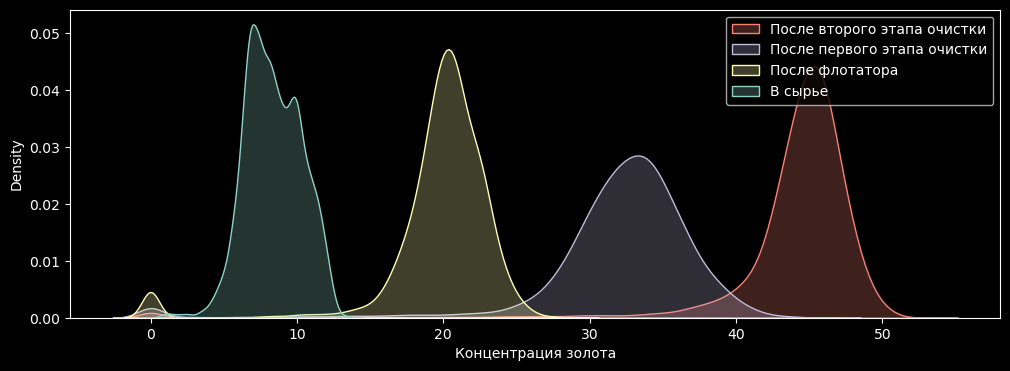

In [15]:
plt.figure(figsize=(12,4))
sns.kdeplot(data=train_df[['rougher.input.feed_au', 'rougher.output.concentrate_au', 
                       'primary_cleaner.output.concentrate_au', 'final.output.concentrate_au']], fill=True)
plt.legend(['После второго этапа очистки', 'После первого этапа очистки', 'После флотатора', 'В сырье'])
plt.xlabel('Концентрация золота')
plt.show()

Концентрация золота в смеси возрастает на каждом этапе обогащения. Распределения имеют нормальную форму

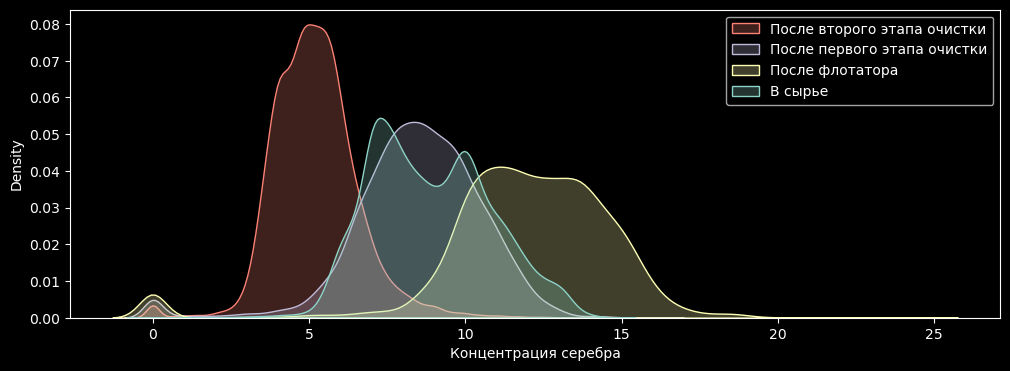

In [16]:
plt.figure(figsize=(12,4))
sns.kdeplot(data=train_df[['rougher.input.feed_ag', 'rougher.output.concentrate_ag', 
                       'primary_cleaner.output.concentrate_ag', 'final.output.concentrate_ag']], fill=True)
plt.legend(['После второго этапа очистки', 'После первого этапа очистки', 'После флотатора', 'В сырье'])
plt.xlabel('Концентрация серебра')
plt.show()

Концентрация серебра в смеси повышается после флотатора (вот возможная причина корреляции между эффективностью обогащения чернового концентрата и содержанием серебра) и снижается в среднем до 5 в конце обогащения. Распределения имеют хвосты, особенно на начальных стадиях. Утолщение в районе нуля показывает, что бывает сырье без содержания серебра.

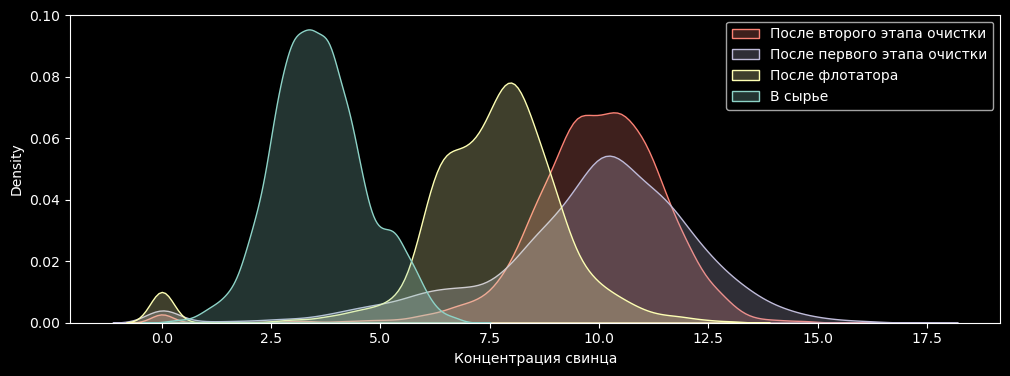

In [17]:
plt.figure(figsize=(12,4))
sns.kdeplot(data=train_df[['rougher.input.feed_pb', 'rougher.output.concentrate_pb', 
                       'primary_cleaner.output.concentrate_pb', 'final.output.concentrate_pb']], fill=True)
plt.legend(['После второго этапа очистки', 'После первого этапа очистки', 'После флотатора', 'В сырье'])
plt.xlabel('Концентрация свинца')
plt.show()

Содержание свинца в смеси растет в процессе обогащения.

#### Вывод
Содержание золота и свинца возростает в процессе обогащения в среднем до 45 и 10 соответственно. Концентрация серебра растет в процессе флотации и снижается на следующих стадиях в среднем до 5. У распределений всех металлов по стадиям присутствует утолщение в районе нуля.

### 2.2. Суммарная концентрация металлов по стадиям.

In [18]:
# Концентрация металлов в начале процесса
start = train_df['rougher.input.feed_au'] + train_df['rougher.input.feed_ag'] + train_df['rougher.input.feed_pb']

# Концентрация металлов после флотатора
rougher = train_df['rougher.output.concentrate_au'] + train_df['rougher.output.concentrate_ag'] \
                         + train_df['rougher.output.concentrate_pb']

# Концентрация металлов после первой стадии очистки
primary_cleaner = train_df['primary_cleaner.output.concentrate_au'] + train_df['primary_cleaner.output.concentrate_ag'] \
                         + train_df['primary_cleaner.output.concentrate_pb']

# Концентрация металлов после второй стадии очистки
final = train_df['final.output.concentrate_au'] + train_df['final.output.concentrate_ag'] \
                         + train_df['final.output.concentrate_pb']

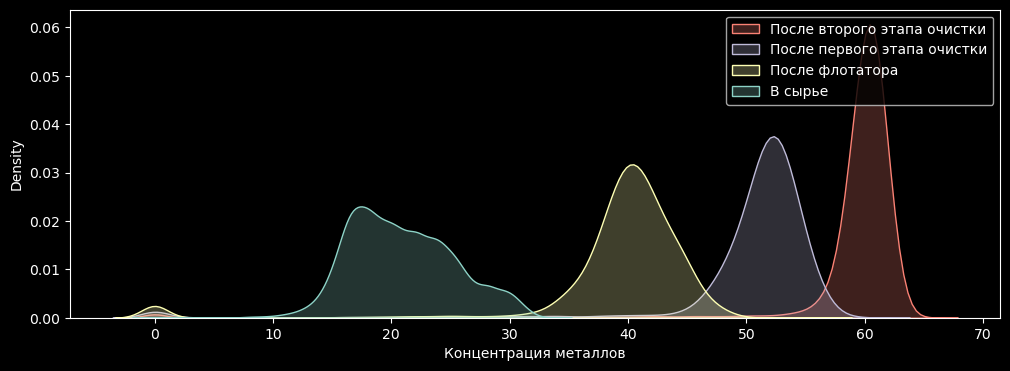

In [19]:
plt.figure(figsize=(12,4))
sns.kdeplot(data=pd.concat([start, rougher, primary_cleaner, final], axis=1), fill=True)
plt.legend(['После второго этапа очистки', 'После первого этапа очистки', 'После флотатора', 'В сырье'])
plt.xlabel('Концентрация металлов')
plt.show()

Распределения суммарных концентраций на разных стадиях процесса имеют утолщение в районе нуля. Это похоже на аномальные значения. Их следует удалить из обучающей выборки. Посмотрим сколько их в датасете

In [20]:
((start == 0) | (rougher == 0) | (primary_cleaner == 0) | (final == 0)).sum()

591

Удалим эти строки

In [21]:
train_df = train_df[~((start == 0) | (rougher == 0) | (primary_cleaner == 0) | (final == 0))]

#### Вывод
Концентрация металлов в процессе очистки возрастает до 60, что соответствует оценкам при исследовании изменения концентрации металлов по стадиям. Дисперсия распределений уменьшается. Присутствует утолщение плотности вероятности распределений суммарных концентраций на разных стадиях процесса. Это похоже на аномальные значения. Исключили эти строки из обучающей выборки

### 2.3. Распределение размера гранул.

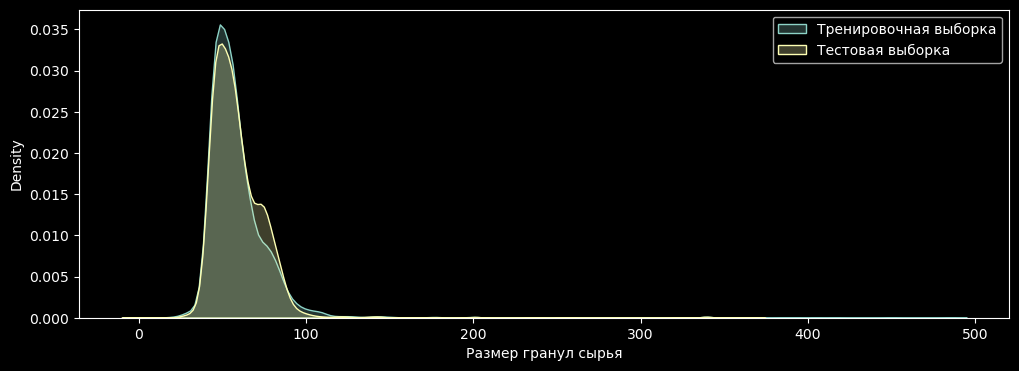

In [22]:
plt.figure(figsize=(12,4))
sns.kdeplot(data=train_df['rougher.input.feed_size'], fill=True)
sns.kdeplot(data=test_df['rougher.input.feed_size'], fill=True)
plt.legend(['Тренировочная выборка', 'Тестовая выборка'])
plt.xlabel('Размер гранул сырья')
plt.show()

#### Вывод
Распределения гранул в тренировочной и тестовой выборках имеют похожую форму. Таким образом, данный параметр не будет искажать оценки модели.

### Вывод
Исследовательский анализ показал возрастание концентрации металлов в смеси в процессе обогащения и снижение дисперсии распределений концентрации. Концентрация золота возрастает на всех этапах процесса. Концентрация серебра возрастает на этапе флотации, а дельше снижается. Концентрация свинца растет до второй стадии очистки. На второй стадии очистки концентрация свинца почти не меняется, но снижается дисперсия. Распределения размера гранул в тренировочной и тестовой выборках очень похожи, поэтому данный параметр не будет искажать результаты оценки модели.

## 3. Построение и проверка моделей.
В процессе предобработки необходимо удалить столбцы, отсутствующие в тестовой выборке, из тренировочной. Заполнение пропусков данных предыдущим валидным значением лучше добавить в пайплайн вместе с стандартизацией параметров и кросс-валидацией. 
### 3.1. Метрика sMAPE.
Оценка модели происходит на основании метрики sMAPE - симметричное среднее абсолютное процентное отклонение. Для использования её в оптимизации моделей необходимо написать функцию в соотвествии с формулой:

<img src= "https://pictures.s3.yandex.net/resources/smape_1576238825.jpg" alt="sMAPE" style="width: 600px;"/>

In [23]:
# Функция для расчета sMAPE
def smape(target, prediction):
    smape = np.sum(np.mean(np.abs(target - prediction) / 
                           ((np.abs(target) + np.abs(prediction)) / 2))) * 100
    return smape

# Превращаем функцию в метрику
smape_score = make_scorer(smape, greater_is_better=False)

### 3.2. Подготовка выборок.
Подготовим тренировочные и тестовые выборки для двух целевых параметров

In [24]:
# Сделаем столбец с датой индексом
train_df.set_index('date', drop=True, inplace=True)
test_df.set_index('date', drop=True, inplace=True)

# Теперь сделаем тренировочную выборку с параметрами, доступными на этапе флотации
rougher_train_X = train_df[
    ['rougher.input.feed_au', 'rougher.input.feed_ag',
       'rougher.input.feed_pb', 'rougher.input.feed_sol',
       'rougher.input.feed_rate', 'rougher.input.feed_size',
       'rougher.input.floatbank10_sulfate',
       'rougher.input.floatbank10_xanthate', 'rougher.state.floatbank10_a_air',
       'rougher.state.floatbank10_a_level', 'rougher.state.floatbank10_b_air',
       'rougher.state.floatbank10_b_level', 'rougher.state.floatbank10_c_air',
       'rougher.state.floatbank10_c_level', 'rougher.state.floatbank10_d_air',
       'rougher.state.floatbank10_d_level', 'rougher.state.floatbank10_e_air',
       'rougher.state.floatbank10_e_level', 'rougher.state.floatbank10_f_air',
       'rougher.state.floatbank10_f_level',
       'rougher.input.floatbank11_sulfate',
       'rougher.input.floatbank11_xanthate',]
]

# Тренировочная выборка с целевым значением на флотации
rougher_train_y = train_df['rougher.output.recovery']

# Тренировочная выборка с параметрами для финального значения эффективности
final_train_X = train_df.drop(['final.output.recovery', *missing_columns], axis=1)

# Тренировочная выборка с финальным значением эффективности
final_train_y = train_df['final.output.recovery']

In [25]:
# Сделаем столбец с датой индексом для полной выборки
full_df.set_index('date', drop=True, inplace=True)

# Тестовая выборка с параметрами флотации
rougher_test_X = test_df[
    ['rougher.input.feed_au', 'rougher.input.feed_ag',
       'rougher.input.feed_pb', 'rougher.input.feed_sol',
       'rougher.input.feed_rate', 'rougher.input.feed_size',
       'rougher.input.floatbank10_sulfate',
       'rougher.input.floatbank10_xanthate', 'rougher.state.floatbank10_a_air',
       'rougher.state.floatbank10_a_level', 'rougher.state.floatbank10_b_air',
       'rougher.state.floatbank10_b_level', 'rougher.state.floatbank10_c_air',
       'rougher.state.floatbank10_c_level', 'rougher.state.floatbank10_d_air',
       'rougher.state.floatbank10_d_level', 'rougher.state.floatbank10_e_air',
       'rougher.state.floatbank10_e_level', 'rougher.state.floatbank10_f_air',
       'rougher.state.floatbank10_f_level',
       'rougher.input.floatbank11_sulfate',
       'rougher.input.floatbank11_xanthate',]
]

# Тестовая выборка с целевым значением на флотации
rougher_test_y = pd.Series(full_df['rougher.output.recovery'], test_df.index)

# Тестовая выборка с параметрами для финального значения эффективности
final_test_X = test_df

# Тестовая выборка с финальным значением эффективности
final_test_y = pd.Series(full_df['final.output.recovery'], test_df.index)

### 3.3. Построение конвейеров моделей.
Для заполнения пропусков в датасете на предыдущее валидное значение внутри пайплайна нужно написать класс заполнителя с методом "ffill".

In [26]:
# Создаем класс для заполнения пропусков предыдущим вылидным значением
class ForwardFillImputer(TransformerMixin, BaseEstimator):
    def __init__(self, columns=None):
        self.columns = columns
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        if self.columns is None:
            self.columns = X.columns
        
        X = X.copy()
        X[self.columns] = X[self.columns].fillna(method='ffill')
        return X

#### 3.3.1. Выбор модели для оценки эффективности обогащения чернового концентрата.

In [27]:
lr_pipe = Pipeline([
    ('imputer1', ForwardFillImputer()),
    ('imputer2', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('regressor', LinearRegression())
])

lr_param_grid = {'regressor__fit_intercept':[True, False]}

grid_lr_rougher = GridSearchCV(lr_pipe, param_grid=lr_param_grid, cv=5, verbose=3, scoring=smape_score)

grid_lr_rougher.fit(rougher_train_X, rougher_train_y)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV 1/5] END ....regressor__fit_intercept=True;, score=-8.186 total time=   0.0s
[CV 2/5] END ....regressor__fit_intercept=True;, score=-6.023 total time=   0.0s
[CV 3/5] END ....regressor__fit_intercept=True;, score=-4.693 total time=   0.0s
[CV 4/5] END ....regressor__fit_intercept=True;, score=-4.495 total time=   0.0s
[CV 5/5] END ....regressor__fit_intercept=True;, score=-9.164 total time=   0.0s
[CV 1/5] END .regressor__fit_intercept=False;, score=-198.853 total time=   0.0s
[CV 2/5] END .regressor__fit_intercept=False;, score=-197.577 total time=   0.0s
[CV 3/5] END .regressor__fit_intercept=False;, score=-192.739 total time=   0.0s
[CV 4/5] END .regressor__fit_intercept=False;, score=-186.255 total time=   0.0s
[CV 5/5] END .regressor__fit_intercept=False;, score=-191.500 total time=   0.0s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('imputer1', ForwardFillImputer()),
                                       ('imputer2',
                                        SimpleImputer(strategy='median')),
                                       ('scaler', StandardScaler()),
                                       ('regressor', LinearRegression())]),
             param_grid={'regressor__fit_intercept': [True, False]},
             scoring=make_scorer(smape, greater_is_better=False), verbose=3)

In [28]:
grid_lr_rougher.best_score_, grid_lr_rougher.best_params_

(-6.512001457867031, {'regressor__fit_intercept': True})

In [29]:
rfr_pipe = Pipeline([
    ('imputer', ForwardFillImputer()),
    ('regressor', RandomForestRegressor(n_jobs=-1, random_state=12))
])

rfr_param_grid = {'regressor__max_depth': range(5, 16, 5),
                 'regressor__n_estimators': range(200, 301, 50),
                 'regressor__min_samples_leaf': range(35, 46, 5)}

grid_rfr_rougher = GridSearchCV(rfr_pipe, param_grid=rfr_param_grid, cv=3, verbose=3, scoring=smape_score)

grid_rfr_rougher.fit(rougher_train_X, rougher_train_y)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
[CV 1/3] END regressor__max_depth=5, regressor__min_samples_leaf=35, regressor__n_estimators=200;, score=-7.689 total time=   4.1s
[CV 2/3] END regressor__max_depth=5, regressor__min_samples_leaf=35, regressor__n_estimators=200;, score=-4.980 total time=   2.4s
[CV 3/3] END regressor__max_depth=5, regressor__min_samples_leaf=35, regressor__n_estimators=200;, score=-6.242 total time=   2.0s
[CV 1/3] END regressor__max_depth=5, regressor__min_samples_leaf=35, regressor__n_estimators=250;, score=-7.687 total time=   2.5s
[CV 2/3] END regressor__max_depth=5, regressor__min_samples_leaf=35, regressor__n_estimators=250;, score=-4.992 total time=   2.6s
[CV 3/3] END regressor__max_depth=5, regressor__min_samples_leaf=35, regressor__n_estimators=250;, score=-6.249 total time=   2.7s
[CV 1/3] END regressor__max_depth=5, regressor__min_samples_leaf=35, regressor__n_estimators=300;, score=-7.676 total time=   3.3s
[CV 2/3] END regressor

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('imputer', ForwardFillImputer()),
                                       ('regressor',
                                        RandomForestRegressor(n_jobs=-1,
                                                              random_state=12))]),
             param_grid={'regressor__max_depth': range(5, 16, 5),
                         'regressor__min_samples_leaf': range(35, 46, 5),
                         'regressor__n_estimators': range(200, 301, 50)},
             scoring=make_scorer(smape, greater_is_better=False), verbose=3)

In [30]:
grid_rfr_rougher.best_score_, grid_rfr_rougher.best_params_

(-6.298930827459523,
 {'regressor__max_depth': 5,
  'regressor__min_samples_leaf': 40,
  'regressor__n_estimators': 200})

In [31]:
knnr_pipe = Pipeline([
    ('imputer', ForwardFillImputer()),
    ('scaler', StandardScaler()),
    ('regressor', KNeighborsRegressor(n_jobs=-1))
])

knnr_param_grid = {'regressor__n_neighbors': range(45, 51, 5),
                 'regressor__weights': ['uniform', 'distance'],
                 'regressor__algorithm': ['ball_tree', 'kd_tree']}

grid_knnr_rougher = GridSearchCV(knnr_pipe, param_grid=knnr_param_grid, cv=3, verbose=3, scoring=smape_score)

grid_knnr_rougher.fit(rougher_train_X, rougher_train_y)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV 1/3] END regressor__algorithm=ball_tree, regressor__n_neighbors=45, regressor__weights=uniform;, score=-8.745 total time=   0.2s
[CV 2/3] END regressor__algorithm=ball_tree, regressor__n_neighbors=45, regressor__weights=uniform;, score=-5.425 total time=   0.2s
[CV 3/3] END regressor__algorithm=ball_tree, regressor__n_neighbors=45, regressor__weights=uniform;, score=-7.744 total time=   0.2s
[CV 1/3] END regressor__algorithm=ball_tree, regressor__n_neighbors=45, regressor__weights=distance;, score=-8.735 total time=   0.2s
[CV 2/3] END regressor__algorithm=ball_tree, regressor__n_neighbors=45, regressor__weights=distance;, score=-5.419 total time=   0.2s
[CV 3/3] END regressor__algorithm=ball_tree, regressor__n_neighbors=45, regressor__weights=distance;, score=-7.734 total time=   0.2s
[CV 1/3] END regressor__algorithm=ball_tree, regressor__n_neighbors=50, regressor__weights=uniform;, score=-8.749 total time=   0.2s
[CV 2/

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('imputer', ForwardFillImputer()),
                                       ('scaler', StandardScaler()),
                                       ('regressor',
                                        KNeighborsRegressor(n_jobs=-1))]),
             param_grid={'regressor__algorithm': ['ball_tree', 'kd_tree'],
                         'regressor__n_neighbors': range(45, 51, 5),
                         'regressor__weights': ['uniform', 'distance']},
             scoring=make_scorer(smape, greater_is_better=False), verbose=3)

In [32]:
grid_knnr_rougher.best_score_, grid_knnr_rougher.best_params_

(-7.290938390750067,
 {'regressor__algorithm': 'ball_tree',
  'regressor__n_neighbors': 50,
  'regressor__weights': 'distance'})

Лучшее значение метрики sMAPE показала модель случайного леса. Её и возьмем для оценки эффективности обогащения чернового концентрата на тестовой выборке.

#### 3.3.2. Выбор модели для оценки эффективности обогащения финального концентрата.

In [33]:
grid_lr_final = GridSearchCV(lr_pipe, param_grid=lr_param_grid, cv=5, verbose=3, scoring=smape_score)

grid_lr_final.fit(final_train_X, final_train_y)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV 1/5] END ...regressor__fit_intercept=True;, score=-10.543 total time=   0.1s
[CV 2/5] END ....regressor__fit_intercept=True;, score=-8.296 total time=   0.1s
[CV 3/5] END ....regressor__fit_intercept=True;, score=-8.782 total time=   0.1s
[CV 4/5] END ....regressor__fit_intercept=True;, score=-8.807 total time=   0.1s
[CV 5/5] END ...regressor__fit_intercept=True;, score=-11.213 total time=   0.0s
[CV 1/5] END .regressor__fit_intercept=False;, score=-192.276 total time=   0.1s
[CV 2/5] END .regressor__fit_intercept=False;, score=-184.820 total time=   0.0s
[CV 3/5] END .regressor__fit_intercept=False;, score=-189.768 total time=   0.0s
[CV 4/5] END .regressor__fit_intercept=False;, score=-183.849 total time=   0.1s
[CV 5/5] END .regressor__fit_intercept=False;, score=-190.360 total time=   0.1s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('imputer1', ForwardFillImputer()),
                                       ('imputer2',
                                        SimpleImputer(strategy='median')),
                                       ('scaler', StandardScaler()),
                                       ('regressor', LinearRegression())]),
             param_grid={'regressor__fit_intercept': [True, False]},
             scoring=make_scorer(smape, greater_is_better=False), verbose=3)

In [34]:
grid_lr_final.best_score_, grid_lr_final.best_params_

(-9.528133436618777, {'regressor__fit_intercept': True})

In [35]:
grid_rfr_final = GridSearchCV(rfr_pipe, param_grid=rfr_param_grid, cv=3, verbose=3, scoring=smape_score)

grid_rfr_final.fit(final_train_X, final_train_y)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
[CV 1/3] END regressor__max_depth=5, regressor__min_samples_leaf=35, regressor__n_estimators=200;, score=-8.923 total time=   4.8s
[CV 2/3] END regressor__max_depth=5, regressor__min_samples_leaf=35, regressor__n_estimators=200;, score=-9.038 total time=   4.3s
[CV 3/3] END regressor__max_depth=5, regressor__min_samples_leaf=35, regressor__n_estimators=200;, score=-12.553 total time=   4.4s
[CV 1/3] END regressor__max_depth=5, regressor__min_samples_leaf=35, regressor__n_estimators=250;, score=-8.918 total time=   5.7s
[CV 2/3] END regressor__max_depth=5, regressor__min_samples_leaf=35, regressor__n_estimators=250;, score=-9.040 total time=   5.4s
[CV 3/3] END regressor__max_depth=5, regressor__min_samples_leaf=35, regressor__n_estimators=250;, score=-12.520 total time=   5.4s
[CV 1/3] END regressor__max_depth=5, regressor__min_samples_leaf=35, regressor__n_estimators=300;, score=-8.911 total time=   6.9s
[CV 2/3] END regress

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('imputer', ForwardFillImputer()),
                                       ('regressor',
                                        RandomForestRegressor(n_jobs=-1,
                                                              random_state=12))]),
             param_grid={'regressor__max_depth': range(5, 16, 5),
                         'regressor__min_samples_leaf': range(35, 46, 5),
                         'regressor__n_estimators': range(200, 301, 50)},
             scoring=make_scorer(smape, greater_is_better=False), verbose=3)

In [36]:
grid_rfr_final.best_score_, grid_rfr_final.best_params_

(-10.021053241050323,
 {'regressor__max_depth': 10,
  'regressor__min_samples_leaf': 45,
  'regressor__n_estimators': 250})

In [37]:
grid_knnr_final = GridSearchCV(knnr_pipe, param_grid=knnr_param_grid, cv=3, verbose=3, scoring=smape_score)

grid_knnr_final.fit(final_train_X, final_train_y)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV 1/3] END regressor__algorithm=ball_tree, regressor__n_neighbors=45, regressor__weights=uniform;, score=-9.893 total time=   0.5s
[CV 2/3] END regressor__algorithm=ball_tree, regressor__n_neighbors=45, regressor__weights=uniform;, score=-10.005 total time=   0.5s
[CV 3/3] END regressor__algorithm=ball_tree, regressor__n_neighbors=45, regressor__weights=uniform;, score=-11.841 total time=   0.5s
[CV 1/3] END regressor__algorithm=ball_tree, regressor__n_neighbors=45, regressor__weights=distance;, score=-9.890 total time=   0.5s
[CV 2/3] END regressor__algorithm=ball_tree, regressor__n_neighbors=45, regressor__weights=distance;, score=-10.026 total time=   0.6s
[CV 3/3] END regressor__algorithm=ball_tree, regressor__n_neighbors=45, regressor__weights=distance;, score=-11.846 total time=   0.6s
[CV 1/3] END regressor__algorithm=ball_tree, regressor__n_neighbors=50, regressor__weights=uniform;, score=-9.900 total time=   0.6s
[C

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('imputer', ForwardFillImputer()),
                                       ('scaler', StandardScaler()),
                                       ('regressor',
                                        KNeighborsRegressor(n_jobs=-1))]),
             param_grid={'regressor__algorithm': ['ball_tree', 'kd_tree'],
                         'regressor__n_neighbors': range(45, 51, 5),
                         'regressor__weights': ['uniform', 'distance']},
             scoring=make_scorer(smape, greater_is_better=False), verbose=3)

In [38]:
grid_knnr_final.best_score_, grid_knnr_final.best_params_

(-10.55425159855058,
 {'regressor__algorithm': 'ball_tree',
  'regressor__n_neighbors': 50,
  'regressor__weights': 'uniform'})

Лучшее значение метрики sMAPE показала модель линейной регрессии. Её и возьмем для оценки эффективности обогащения финального концентрата на тестовой выборке.

### 3.3. Проверка моделей.
Проверим лучшие модели на тестовой выборке и рассчитаем итоговое sMAPE для всего процесса по формуле:

<img src= "https://pictures.s3.yandex.net/resources/_smape_1576239054.jpg" alt="total_sMAPE" style="width: 600px;"/>

In [39]:
# Оценка эффективности обогащения чернового концентрата
rougher_pred = grid_rfr_rougher.predict(rougher_test_X)
rougher_smape = smape(rougher_test_y, rougher_pred)

# Оценка эффективности обогащения финального концентрата
final_pred = grid_lr_final.predict(final_test_X)
final_smape = smape(final_test_y, final_pred)

print(f'Итоговое sMAPE модели: {0.25 * rougher_smape + 0.75 * final_smape:.2f}')

Итоговое sMAPE модели: 7.01


### 3.4. Проверка на адекватность.
Сравним предсказание модели и предсказания наивного регрессора.

In [40]:
# Наивный регрессор для оценки эффективности обогащения чернового концентрата
dummy_rougher = DummyRegressor(strategy='mean')
dummy_rougher.fit(rougher_train_X, rougher_train_y)
dummy_rougher_pred = dummy_rougher.predict(rougher_test_X)
dummy_rougher_smape = smape(rougher_test_y, dummy_rougher_pred)

# Наивный регрессор для оценки эффективности обогащения финального концентрата
dummy_final = DummyRegressor(strategy='mean')
dummy_final.fit(final_train_X, final_train_y)
dummy_final_pred = dummy_final.predict(final_test_X)
dummy_final_smape = smape(final_test_y, dummy_final_pred)

print(f'Итоговое sMAPE наивного регрессора: {0.25 * dummy_rougher_smape + 0.75 * dummy_final_smape:.2f}')

Итоговое sMAPE наивного регрессора: 8.47


### Вывод
Для предсказания эффективности обогащения чернового и финального концентрата были проверны модели линейной регрессии, случайного леса и к-ближайших соседей. Лучшие значения метрики sMAPE для эффективности обогащения чернового концентрата показала модель случайного леса, а для финального - линейной регрессии, которые и были приняты для проверки на тестовой выборке. Значение итогового sMAPE лучше, чем предсказания наивного регрессора.

## Заключение
В исследовании были изучены данные процесса обогащения золотосодержащей руды. Исходные данные содержат достаточно большое количество признаков (86), при этом в тестовой выборке отсутствуют признаки (34 столбца), которые неизвестны в процессе обогащения. Сильная корреляция между эффективностью обогащения финального концентрата и остальными признаками отсутствует. Есть прямая корреляция между эффективностью обогащения чернового концентрата и содержанием в нем серебра, что связано с возрастанием концентрации серебра на флотации. Заметно наличие корреляции между концентрациями золота, серебра и свинца в сырье, а также между серебром и свинцом на входе и в хвостах. Значения эффективности обогащения соответствуют расчетным.

Исследовательский анализ показал возрастание концентрации металлов в смеси в процессе обогащения и снижение дисперсии распределений концентрации. Плотность вероятности распределений суммарной концентрации металлов на разных стадиях показывает утолщение в районе нуля. Решено исключить аномальные значения из обучающей выборки в количестве 591 строки. Концентрация золота возрастает на всех этапах процесса. Концентрация серебра возрастает на этапе флотации, а дальше снижается. Концентрация свинца растет до второй стадии очистки. На второй стадии очистки концентрация свинца почти не меняется, но снижается дисперсия. Распределения размера гранул в тренировочной и тестовой выборках очень похожи, поэтому данный параметр не будет искажать результаты оценки модели.

Для предсказания эффективности обогащения чернового и финального концентрата были проверны модели линейной регрессии, случайного леса и к-ближайших соседей. Лучшие значения метрики sMAPE для эффективности обогащения чернового концентрата показала модель случайного леса, а для финального - линейной регрессии, которые и были приняты для проверки на тестовой выборке. Значение итогового sMAPE равно 7.01, что лучше оценки наивного регрессора, предсказывающего среднее значение (8.47).

Таким образом, финальная модель подходит в качестве прототипа для оценки эффективности обогащения золотосодержащей руды.